In [ ]:
# install full version
!pip install pycaret[full]

# Pre-Processing

## Import Dependencies

In [2]:
# Libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pickle

# Data preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Model evaluation and building
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_squared_error

# Additional libraries
import re
import sys
import warnings
import os

# Configuration
np.set_printoptions(threshold=sys.maxsize)
warnings.filterwarnings("ignore")

# Kaggle specific
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Read the dataset
df = pd.read_csv("/kaggle/input/dataslayer/train.csv/train.csv")


/kaggle/input/dataslayer/sample_submission.csv
/kaggle/input/dataslayer/Test_Tentan.csv
/kaggle/input/dataslayer/train.csv/train.csv
/kaggle/input/dataslayer/test.csv/test.csv
/kaggle/input/test-tentan-prepro/Test_Tentan.csv


## Penyesuaian Nama Variabel

In [3]:
df["Vehicle"] = df["Vehicle Class"]
df["Engine"] = df["Engine Size(L)"]
df["Fuel"] = df["Fuel Type"] 
df["City"] = df["Fuel Consumption City"]
df["Hwy"] = df["Fuel Consumption Hwy"]
df["Comb"] = df["Fuel Consumption Comb"]
df["Emissions"] = df["CO2 Emissions(g/km)"]

In [4]:
# Membuang variabel dengan nama yang lama
drop = ["Id", "Vehicle Class", "Engine Size(L)", "Fuel Type", "Fuel Consumption City", "Fuel Consumption Hwy", "Fuel Consumption Comb", "CO2 Emissions(g/km)"]
df = df.drop(drop, axis=1)

## Handling Missing Values

In [5]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Jumlah nilai unik di kolom '{column}': {len(unique_values)}")
    if len(unique_values)<=50:
        print(f"Nilai unik di kolom '{column}': {unique_values}")
    print()

Jumlah nilai unik di kolom 'Make': 21
Nilai unik di kolom 'Make': ['MITSU' 'TOYOTI' 'MATSUDA' 'CHEVO' 'DOGE' 'BMV' 'LECUS' 'KIO' 'FOLD'
 'JIPU' 'NIRRAN' 'CADILUXE' 'FOLKSWA' 'BARUSU' 'GONDA' 'LAND CRAWLER'
 'RYUNDAI' 'TOLVO' 'FIAR' 'ASURA' 'LAMBOGI']

Jumlah nilai unik di kolom 'Cylinders': 15
Nilai unik di kolom 'Cylinders': ['4.0' '6.0' '8.0' 'unknown' 'na' '3.0' '10.0' 'not-recorded'
 'unspecified' '12.0' nan '5.0' 'missing' 'not-available' 'unestablished']

Jumlah nilai unik di kolom 'Transmission': 33
Nilai unik di kolom 'Transmission': ['AV8' 'A5' 'AS6' 'A6' 'M6' 'M5' 'A9' 'AS8' 'AV' 'AM6' 'AS10' 'A8' 'AS9'
 'unestablished' 'AM8' 'AM7' 'AV7' 'A4' 'not-recorded' 'AV6' 'missing'
 'unspecified' 'AV10' 'AS5' 'M7' 'A10' 'na' 'AS7' 'not-available'
 'unknown' nan 'A7' 'AM9']

Jumlah nilai unik di kolom 'Vehicle': 24
Nilai unik di kolom 'Vehicle': ['SUV - SMALL' 'PICKUP TRUCK - SMALL' 'COMPACT' 'VAN - PASSENGER'
 'MID-SIZE' 'SUV - STANDARD' 'STATION WAGON - SMALL' 'FULL-SIZE'
 'TWO-SEATE

Ada yang unik disini data yang hilang tidak hanya berupa NaN, akan tetapi ada jenis NaN lain yang "bersembunyi".

Disini kita mendapatkan values ini ['unknown', 'na', 'not-available', 'not-recorded', 'missing', 'unspecified', 'unestablished'] yang seharusnya diidentifikasi sebagai NaN dalam jumlah besar.

In [6]:
missing_values = ['unknown', 'na', 'not-available', 'not-recorded', 'missing', 'unspecified', 'unestablished']

def count_missing_values(df, missing_values):
    count_dict = {}
    
    for column in df.columns:
        counts = {value: (df[column] == value).sum() for value in missing_values}
        count_dict[column] = counts
    
    counts_df = pd.DataFrame(count_dict)
    
    nan_counts = df.isna().sum()
    nan_counts.name = 'NaN'
    counts_df = pd.concat([counts_df, nan_counts.to_frame().T])
    
    return counts_df

In [7]:
count_missing_values(df, missing_values)

,Make,Cylinders,Transmission,Vehicle,Engine,Fuel,City,Hwy,Comb,Emissions
unknown,0,403,129,188,474,189,0,0,0,0
na,0,409,147,220,454,163,0,0,0,0
not-available,0,399,137,189,485,162,402,423,434,0
not-recorded,0,819,253,372,980,330,0,0,0,0
missing,0,441,145,167,462,168,0,0,0,0
unspecified,0,423,133,189,543,214,0,0,0,0
unestablished,0,431,129,187,473,170,0,0,0,0
NaN,0,1198,410,539,1393,546,1568,1701,1674,0


**Mengidentifikasi nilai tersebut sebagai NaN**

In [8]:
missing_values = ['unknown', 'na', 'not-available', 'not-recorded', 'missing', 'unspecified', 'unestablished']

for column in df.columns:
    df[column] = df[column].replace(missing_values, np.nan)

In [9]:
count_missing_values(df, missing_values)

,Make,Cylinders,Transmission,Vehicle,Engine,Fuel,City,Hwy,Comb,Emissions
unknown,0,0,0,0,0,0,0,0,0,0
na,0,0,0,0,0,0,0,0,0,0
not-available,0,0,0,0,0,0,0,0,0,0
not-recorded,0,0,0,0,0,0,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0
unspecified,0,0,0,0,0,0,0,0,0,0
unestablished,0,0,0,0,0,0,0,0,0,0
NaN,0,4523,1483,2051,5264,1942,1970,2124,2108,0


**Sekarang semua nilai yang seharusnya menjadi missing values sudah diidentifikasi sebagai NaN**

## Penyetaraan Satuan
Untuk Variabel City, Hwy, Comb

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54937 entries, 0 to 54936
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Make          54937 non-null  object
 1   Cylinders     50414 non-null  object
 2   Transmission  53454 non-null  object
 3   Vehicle       52886 non-null  object
 4   Engine        49673 non-null  object
 5   Fuel          52995 non-null  object
 6   City          52967 non-null  object
 7   Hwy           52813 non-null  object
 8   Comb          52829 non-null  object
 9   Emissions     54937 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 4.2+ MB


In [11]:
def find_units(data):
    units = set()
    for column in data.columns:
        for value in data[column]:
            matches = re.findall(r'\b\d+(\.\d+)?\s*(L\/10km|L\/100km|km\/L|mpg Imp\.|MPG \(AS\)|liters per 100 km)\b', str(value))
            if matches:
                units.update([match[1] for match in matches])
    return units

found_units = find_units(df[['Hwy', 'City', 'Comb']])

print(found_units)


{'km/L', 'L/100km', 'liters per 100 km', 'L/10km'}


Disini kita menemukan beberapa satuan yang harus dikonversi
{'L/10km', 'L/100km', 'litersper100km', 'km/L'}
namun ketika dicari manual, kami menemukan faktor satuan konversi lainnya yaitu 'kmperl', 'mpgimp.', 'mpg'

In [12]:
# Faktor Konversi
KM_PER_MILE = 1.60934
LITERS_PER_GALLON_IMP = 4.54609
LITERS_PER_GALLON_US = 3.78541

def convert_fuel_consumption(value):
    if pd.isnull(value) or value == '-1' or value == '0':
        return np.nan  # Memastikan tidak terjadi error
    try:
        value = value.lower().replace(' ', '')  # Merubah data menjadi tulisan nonkapital dan menghapu spasi
        if 'litersper100km' in value:
            return float(value.split('litersper100km')[0])
        elif 'l/100km' in value:
            return float(value.split('l/100km')[0])
        elif 'l/10km' in value:
            return float(value.split('l/10km')[0]) * 10
        elif 'kmperl' in value:
            return 100 / float(value.split('kmperl')[0])
        elif 'mpgimp.' in value:
            return 100 / (float(value.split('mpgimp.')[0]) * KM_PER_MILE / LITERS_PER_GALLON_IMP)
        elif 'mpg' in value and 'mpgimp.' not in value:
            return 100 / (float(value.split('mpg')[0]) * KM_PER_MILE / LITERS_PER_GALLON_US)
        else:
            return np.nan  # jika satuan tidak diketahui, maka kita ubah menjadi NaN
    except (ValueError, IndexError):
        return np.nan

In [13]:
df['City'] = df['City'].apply(convert_fuel_consumption)
df['Hwy'] = df['Hwy'].apply(convert_fuel_consumption)
df['Comb'] = df['Comb'].apply(convert_fuel_consumption)

Jika berhasil mengkonversi semua maka data type yang sebelumnya object akan berubah menjadi float

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54937 entries, 0 to 54936
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Make          54937 non-null  object 
 1   Cylinders     50414 non-null  object 
 2   Transmission  53454 non-null  object 
 3   Vehicle       52886 non-null  object 
 4   Engine        49673 non-null  object 
 5   Fuel          52995 non-null  object 
 6   City          45897 non-null  float64
 7   Hwy           45868 non-null  float64
 8   Comb          45808 non-null  float64
 9   Emissions     54937 non-null  int64  
dtypes: float64(3), int64(1), object(6)
memory usage: 4.2+ MB


Disini karena variabel city, hwy, dan comb sudah memiliki data type float yang mengidentifikasikan bahwa proses konversi sudah terjadi pada semua nilai dalam data.

## Imputasi Missing Values

Karena sebelumnya terlihat bahwa masih banyak variabel-variabel yang memiliki missing value, jadi disini kita akan melakukan imputasi terhadap variabel-variabel ini. Dengan 3 pendekatan Imputasi:

* Variabel yang saling berhubungan (City, Hwy, Comb)
* Variabel Kategorik
* Variabel Numerik

Adapun disini yang dikategorikan sebagai:
* variabel kategorik adalah ['Transmission','Make', 'Vehicle', 'Fuel']]
* variabel Numerik adalah ['City', 'Hwy', 'Comb']

### Imputasi variabel yang saling berhubungan (City, Hwy, Comb)

Merujuk pada pernyataan ini
> Fuel Consumption Comb (Konsumsi Bahan Bakar Gabungan) Kolom ini menampilkan rating konsumsi bahan bakar yang dihitung sebagai campuran 55% berkendara di kota (Fuel Consumption City) dan 45% berkendara di jalan tol (Fuel Consumption Hwy)

#### imputasi 'City' jika 'Hwy' dan 'Comb' tidak NaN

In [15]:
df.loc[df['City'].isna() & df['Hwy'].notna() & df['Comb'].notna(), 'City'] = (df['Comb'] - 0.45 * df['Hwy']) / 0.55

#### imputasi 'Hwy' jika 'City' dan 'Comb' tidak NaN

In [16]:
df.loc[df['Hwy'].isna() & df['City'].notna() & df['Comb'].notna(), 'Hwy'] = (df['Comb'] - 0.55 * df['City']) / 0.45

#### imputasi 'Comb' jika 'City' dan 'Hwy' tidak NaN

In [17]:
df.loc[df['Comb'].isna() & df['City'].notna() & df['Hwy'].notna(), 'Comb'] = 0.55 * df['City'] + 0.45 * df['Hwy']

In [18]:
df[['City','Hwy','Comb']].isna().sum()

City    2831
Hwy     2825
Comb    2852
dtype: int64

Disini karena masing-masing variabel City, Hwy, Comb masih memiliki missing values, hal ini kemungkinan disebabkan dalam 1 baris mungkin ada 2 yang NaN, atau malah ketiganya. Oleh karena itu dalam proses selanjutnya akan kembali dilakukan imputasi terhadap variabel ini sebagai variabel numerik.

## Imputasi Variabel Kategorikal
['Transmission','Make', 'Vehicle', 'Fuel']]

In [19]:
df['Fuel'] = df['Fuel'].astype('category')
df['Transmission'] = df['Transmission'].astype('category')
df['Vehicle'] = df['Vehicle'].astype('category')
df['Make'] = df['Make'].astype('category')
df['Engine'] = pd.to_numeric(df['Engine'], errors='coerce')
df['Cylinders'] = pd.to_numeric(df['Cylinders'], errors='coerce')

### Encoding Variabel Kategorikal sebelum imputasi

In [20]:
def encode_categorical_columns(df, categorical_columns):
    encoders = {}
    for col in categorical_columns:
        if df[col].dtype == 'object':
            encoder = LabelEncoder()
            df[col] = encoder.fit_transform(df[col].astype(str))
            encoders[col] = encoder
    return df, encoders

### Proses Imputasi Variabel Kategorikal

1. Pilihan Variabel untuk Imputasi:

LightGBM menggunakan kolom-kolom lain dalam categorical_columns sebagai variabel untuk mengimputasi nilai yang hilang dalam setiap kolom yang dipilih untuk diimputasi. Misalnya, jika 'Vehicle' sedang diimputasi, 'Fuel', 'Transmission', dan 'Make' dapat digunakan sebagai variabel untuk mengisi nilai yang hilang dalam 'Vehicle'.

2. Mekanisme Imputasi:

LightGBM membangun model untuk setiap kolom yang ingin diimputasi ('Vehicle', 'Fuel', 'Transmission'). Setelah memilih kolom-kolom lain sebagai variabel, ia menggunakan model LGBMClassifier yang telah disesuaikan dengan variabel-variabel tersebut untuk memprediksi nilai yang hilang dalam kolom yang sedang diimputasi.

Setelah proses imputasi selesai, LightGBM menghasilkan nilai yang diimputasi untuk setiap kolom yang ditentukan. Kolom yang telah diimputasi tersebut menjadi bagian dari dataframe yang baru, dengan nilai-nilai yang sebelumnya kosong sekarang terisi.

3. Iterasi pada Imputasi:

LightGBM akan mengulangi proses yang sama untuk setiap kolom yang hendak diimputasi, membangun model berbeda untuk setiap kolom tersebut dengan menggunakan variabel dari kolom-kolom lainnya yang ada dalam categorical_columns.

Apabila suatu kolom sudah terisi setelah proses imputasi, maka kolom tersebut tidak lagi diikutsertakan dalam proses imputasi untuk kolom-kolom selanjutnya. Kolom yang diimputasi sebelumnya tetap menggunakan data asli tanpa imputasi. Sebagai contoh, jika kolom 'Vehicle' telah diimputasi, nilai-nilainya tidak akan ikut dipertimbangkan saat mengimputasi kolom 'Fuel' atau 'Transmission'. Setiap kolom diimputasi secara terpisah dan independen dari kolom lainnya.

In [21]:
def impute_categorical_data_with_lightgbm(df, column_to_impute, categorical_columns, include_emissions=False):
    # Gabungkan data yang hilang dan yang tidak hilang
    combined_df = pd.concat([df[df[column_to_impute].isna()], df[~df[column_to_impute].isna()]])

    # Encode categorical columns
    combined_encoded, encoders = encode_categorical_columns(combined_df.copy(), categorical_columns)

    # Pisahkan kembali data yang hilang dan yang tidak hilang
    df_with_missing_encoded = combined_encoded[combined_encoded[column_to_impute].isna()]
    df_without_missing_encoded = combined_encoded[~combined_encoded[column_to_impute].isna()]

    columns_to_drop = [column_to_impute]
    if not include_emissions and 'Emissions' in df.columns:
        columns_to_drop.append('Emissions')

    X = df_without_missing_encoded.drop(columns=columns_to_drop)
    y = df_without_missing_encoded[column_to_impute]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Membangun dan melatih model LightGBM
    model = LGBMClassifier(
        num_leaves=36, 
        learning_rate=0.04434692015762989, 
        n_estimators=31, 
        min_child_samples=52, 
        subsample=0.9212693252334468, 
        colsample_bytree= 0.8977274711608758, 
        random_state=0
    )

    
    model.fit(X_train, y_train, categorical_feature=[col for col in categorical_columns if col != column_to_impute and col in X.columns])

    # Evaluasi model dengan F1-Score
    y_pred = model.predict(X_test)
    f1_result = f1_score(y_test, y_pred, average='macro')

    # Mengimputasi data yang hilang
    imputed_values = model.predict(df_with_missing_encoded.drop(columns=columns_to_drop))

    # Mengisi nilai yang diimputasi ke dalam dataframe asli
    df.loc[df[column_to_impute].isna(), column_to_impute] = imputed_values

    return df, f1_result

Disini kita mengidentifikasi kolom kategorikal sehingga kita dimasukkan ke fungsi, fungsi bisa langsung mengenali kolom mana yang perlu di encoding.

Disini kita juga perlu mengidentifikasi kolom yang akan di imputasi untuk melakukan prediksi.

In [22]:
# Kolom kategorikal dalam dataset
categorical_columns = ['Transmission','Make', 'Vehicle', 'Fuel'] 

# Kolom yang akan diimputasi
columns_to_impute = ['Vehicle', 'Fuel', 'Transmission']

# Melakukan imputasi untuk setiap kolom
imputation_results_with_lightgbm = {}
for column in columns_to_impute:
    df, f1_result = impute_categorical_data_with_lightgbm(df, column, categorical_columns, include_emissions=True)
    imputation_results_with_lightgbm[column] = f1_result

In [23]:
imputation_results_with_lightgbm

{'Vehicle': 0.7068414144756947,
 'Fuel': 0.7327560206498307,
 'Transmission': 0.6782549642237186}

Didapatkan F1 Score untuk masing-masing variabel lumayan tinggi yaitu kurang lebih diatas 70%

In [24]:
df[['Transmission','Make', 'Vehicle', 'Fuel']].isna().sum()

Transmission    0
Make            0
Vehicle         0
Fuel            0
dtype: int64

Tidak ada lagi kolom yang kosong dalam variabel kategorik

## Imputasi Variabel Numerik

In [25]:
for column in df[['Engine', 'Cylinders','City', 'Hwy', 'Comb', 'City']]:
    unique_values = df[column].unique()
    print(f"Jumlah nilai unik di kolom '{column}': {len(unique_values)}")
    if len(unique_values)<=50:
        print(f"Nilai unik di kolom '{column}': {unique_values}")
    print()

Jumlah nilai unik di kolom 'Engine': 43
Nilai unik di kolom 'Engine': [1.5 nan 2.  1.8 2.4 3.5 2.7 1.6 1.2 2.5 3.2 5.  8.4 1.4 3.8 6.2 4.4 3.
 3.6 5.7 5.2 6.4 2.3 3.3 5.3 6.5 1.  4.  3.7 1.3 4.6 4.8 5.6 2.8 6.  4.2
 4.3 2.2 6.6 5.4 3.4 5.8 6.8]

Jumlah nilai unik di kolom 'Cylinders': 8
Nilai unik di kolom 'Cylinders': [ 4.  6.  8. nan  3. 10. 12.  5.]

Jumlah nilai unik di kolom 'City': 5960

Jumlah nilai unik di kolom 'Hwy': 5591

Jumlah nilai unik di kolom 'Comb': 11455

Jumlah nilai unik di kolom 'City': 5960



In [26]:
def round_to_nearest_valid_cylinder(value):
    valid_values = np.array([3,4, 5,6, 8, 10, 12])
    closest_index = np.abs(valid_values - value).argmin()
    return valid_values[closest_index]

Pemilihan untuk memperlakukan kolom "cylinders" sebagai kolom numerik dan membulatkannya ke nilai terdekat seperti 4, 6, 8, 10, atau 12 dan dilakukan regresi dengan LightGBM didasarkan pada karakteristik dari data itu sendiri dan dinilai lebih efisien.

Meskipun kolom "cylinders" sesungguhnya berupa data rasio yang secara teoritis dapat memiliki nilai desimal, dalam konteks kendaraan, jumlah silinder tidak mungkin berupa nilai desimal. Misalnya, mobil biasanya memiliki jumlah silinder bulat seperti 4, 6, 8, atau 12; jumlah silinder tidak mungkin berupa 4,5 atau 7,2 dalam kendaraan produksi.

Mengapa kita membulatkannya? Karena interpretasi nilai silinder dalam kehidupan nyata tidak memungkinkan adanya jumlah silinder yang tidak berupa bilangan bulat, seperti 5,5 atau 7,2. Dalam prakteknya, kendaraan hanya akan memiliki jumlah silinder yang berupa bilangan bulat. Oleh karena itu, membulatkannya ke nilai terdekat seperti 4, 6, 8, 10, atau 12 dianggap lebih tepat dan sesuai dengan karakteristik data yang dihadapi dalam domain kendaraan.

Memperlakukan variabel "cylinders" seperti ini dapat memberikan hasil yang lebih konsisten dan masuk akal dalam konteks dunia nyata, meskipun secara teknis variabel ini bisa berupa data rasio. Dalam kasus ini, pengambilan keputusan didasarkan pada pengetahuan domain khusus kendaraan dan praktik umum dalam penggunaan variabel tersebut.

In [27]:
def impute_numeric_data_with_lightgbm(df, column_to_impute, categorical_columns, include_emissions=False):
    label_encoders = {}

    # Encode categorical variables
    for col in categorical_columns:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le

    # Menyaring kolom yang memiliki data hilang
    df_with_missing = df[df[column_to_impute].isna()]
    df_without_missing = df[~df[column_to_impute].isna()]

    # Tentukan kolom untuk dihapus
    columns_to_drop = [column_to_impute]
    if not include_emissions and 'Emissions' in df.columns:
        columns_to_drop.append('Emissions')

    # Memisahkan data menjadi fitur dan target
    X = df_without_missing.drop(columns=columns_to_drop)
    y = df_without_missing[column_to_impute]

    # Membagi data untuk training dan testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Membangun dan melatih model LightGBM
    model = lgb.LGBMRegressor(
        num_leaves=48, 
        learning_rate=0.08016715021489174, 
        n_estimators=98, 
        min_child_samples=92, 
        subsample=0.7250831317078859, 
        colsample_bytree=0.9002789518022707, 
        reg_alpha=0.007965333485909299, 
        reg_lambda=0.00644566847407712,
        random_state=0
    )
    model.fit(X_train, y_train)

    # Evaluasi model
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Mengimputasi data yang hilang
    imputed_values = model.predict(df_with_missing.drop(columns=columns_to_drop))

    # Memproses imputasi khusus untuk kolom 'Cylinders' dan 'Gears'
    if column_to_impute == 'Cylinders':
        imputed_values = np.array([round_to_nearest_valid_cylinder(x) for x in imputed_values])

    # Mengisi nilai yang diimputasi ke dalam dataframe asli
    df.loc[df[column_to_impute].isna(), column_to_impute] = imputed_values

    # Mengembalikan data kategorikal ke bentuk asli
    for col, le in label_encoders.items():
        df[col] = le.inverse_transform(df[col])
        
    return df, rmse

In [28]:
# Kolom kategorikal yang akan diikutsertakan dalam proses imputasi
categorical_columns = ["Transmission", 'Make', 'Vehicle', 'Fuel']

# Kolom numerik yang akan diimputasi
numeric_columns_to_impute = ['Engine', 'Cylinders', "City", "Hwy"]

# Melakukan imputasi untuk setiap kolom numerik
imputation_results_with_lightgbm = {}
for column in numeric_columns_to_impute:
    df, rmse = impute_numeric_data_with_lightgbm(df, column, categorical_columns, include_emissions=True)
    imputation_results_with_lightgbm[column] = rmse

In [29]:
# Menghitung ulang 'Comb' sesuai aturan setelah imputasi 'City' dan 'Hwy'
df.loc[df['Comb'].isna() & df['City'].notna() & df['Hwy'].notna(), 'Comb'] = 0.55 * df['City'] + 0.45 * df['Hwy']
#imputation_results_with_lightgbm['Comb'] = np.nan  # Tidak ada RMSE untuk 'Comb' karena dihitung dari 'City' dan 'Hwy'

In [30]:
# Menampilkan hasil imputasi
imputation_results_with_lightgbm

{'Engine': 0.18143299954859768,
 'Cylinders': 0.06135224353639902,
 'City': 0.41771425759621955,
 'Hwy': 0.2288179169879608}

In [31]:
df[['Engine', 'Cylinders','City', 'Hwy', 'Comb', 'City']].describe()

,Engine,Cylinders,City,Hwy,Comb,City
count,54937.000000,54937.000000,54937.000000,54937.000000,54937.000000,54937.000000
mean,2.977998,5.292845,12.578604,9.126729,11.023319,12.578604
std,1.300677,1.599776,3.827754,2.340302,2.904889,3.827754
min,1.000000,3.000000,4.119417,3.988652,4.380000,4.119417
25%,2.000000,4.000000,9.999350,7.500000,8.940139,9.999350
50%,2.500000,4.000000,11.800000,8.598452,10.408314,11.800000
75%,3.600000,6.000000,15.097896,10.400000,12.890000,15.097896
max,8.400000,12.000000,30.500000,20.500000,25.316456,30.500000


RMSE dari variabel secara keseluruhan cenderung melakukan prediksi yang sangat dekat dengan nilai sebenarnya.

1. Variabel Engine: 0.18143299954859768

Dalam konteks ini, jika RMSE untuk variabel 'Engine' adalah 0.18 dengan rentang nilai 1 hingga 8.4, itu berarti jika kita memiliki sebuah data yang memiliki nilai 'Engine' sebenarnya sebesar 1 liter, model prediktif kita kemungkinan memprediksi nilainya sekitar 1.1 liter.

Sebuah RMSE sekecil itu menunjukkan bahwa model secara keseluruhan cenderung melakukan prediksi yang sangat dekat dengan nilai sebenarnya. Dalam kasus ini, kesalahan prediksi hanya sekitar 0.1 liter, yang mungkin dianggap sebagai kesalahan yang cukup kecil dalam memperkirakan ukuran mesin suatu kendaraan.

2. Variabel Cylinders: 0.06135224353639902

Dalam konteks ini, jika RMSE untuk variabel 'Cylinders' adalah 0.06 dengan rentang nilai 3-12, itu berarti jika kita memiliki sebuah data yang memiliki 'Cylinders' sebenarnya sebesar 3 maka model prediktif kita memprediksi nilainya sekitar 3,06. Namun hal ini dianulir dengan penggunaan fungsi yang membulatkan kenilai terdekat. Jadi nilai yang diimputasi ke nilai terdekat, nilai 3,06 akan dijadikan menjadi 3

3. Variabel City dan Hwy: {0.41771425759621955 dan 0.2288179169879608}

Untuk variabel 'City' dan 'Highway', RMSE masing-masing adalah 0.4177 dan 0.2288. Ini menunjukkan seberapa dekat model memprediksi konsumsi bahan bakar di kota dan jalan raya dengan nilai sebenarnya. Misalnya, jika model memprediksi konsumsi bahan bakar kota sebesar 8 liter per 100 km, nilai sebenarnya kemungkinan akan sekitar 8 ± 0.4177 liter per 100 km, demikian juga untuk konsumsi bahan bakar di jalan raya.

Secara keseluruhan, RMSE yang kecil untuk setiap variabel menunjukkan bahwa model secara umum memiliki kemampuan yang baik dalam memprediksi nilai-nilai ini. Hal ini mengindikasikan bahwa model cenderung memberikan prediksi yang sangat dekat dengan nilai sebenarnya untuk setiap variabel yang diamati. Namun, penting untuk diingat bahwa interpretasi ini didasarkan pada RMSE saja dan tidak memberikan informasi tentang potensi kecenderungan atau pola kesalahan spesifik yang mungkin dimiliki model.

In [32]:
 df[['Engine', 'Cylinders','City', 'Hwy', 'Comb', 'City']].isna().sum()

Engine       0
Cylinders    0
City         0
Hwy          0
Comb         0
City         0
dtype: int64

In [33]:
for column in df[['Engine', 'Cylinders','City', 'Hwy', 'Comb', 'City']]:
    unique_values = df[column].unique()
    print(f"Jumlah nilai unik di kolom '{column}': {len(unique_values)}")
    if len(unique_values)<=50:
        print(f"Nilai unik di kolom '{column}': {unique_values}")
    print()

Jumlah nilai unik di kolom 'Engine': 4308

Jumlah nilai unik di kolom 'Cylinders': 7
Nilai unik di kolom 'Cylinders': [ 4.  6.  8.  3. 10. 12.  5.]

Jumlah nilai unik di kolom 'City': 8777

Jumlah nilai unik di kolom 'Hwy': 8363

Jumlah nilai unik di kolom 'Comb': 14286

Jumlah nilai unik di kolom 'City': 8777



In [34]:
df.isna().sum()

Make            0
Cylinders       0
Transmission    0
Vehicle         0
Engine          0
Fuel            0
City            0
Hwy             0
Comb            0
Emissions       0
dtype: int64

Sekarang semua variabel sudah selesai di imputasi

## Penambahan Variabel

Efisiensi Mesin yang merupakan rasio dari ukuran mesin yang digunakan dalam liter (yang direpresentasikan oleh variabel 'Engine') dibagi jumlah silinder (yang direpresentasikan oleh variabel 'Cylinders')

https://repository.its.ac.id/56496/1/03211650010012-Master_Thesis.pdf

https://repository.its.ac.id/56496/

"Efisiensi mesin kendaraan merupakan faktor penting dalam emisi CO2 karena efisiensi mesin yang tinggi dapat mengurangi konsumsi bahan bakar, sehingga menghasilkan emisi CO2 yang lebih rendah. Beberapa penelitian menunjukkan bahwa efisiensi mesin dan efisiensi pembakaran mempengaruhi emisi gas buang, termasuk emisi CO2, dari kendaraan bermotor. Sebagai contoh, kendaraan dengan rasio kompresi mesin yang tinggi cenderung lebih efisien dan menghasilkan emisi CO2 yang lebih rendah dibandingkan dengan model mesin sebelumnya. Selain itu, konsumsi bahan bakar merupakan faktor terpenting dalam pengukuran gas buang karena mempengaruhi emisi, dan efisiensi mesin mempengaruhi konsumsi bahan bakar. Oleh karena itu, peningkatan efisiensi mesin kendaraan dapat berkontribusi pada pengurangan emisi CO2 secara signifikan."

Oleh karena itu, diperlukan variabel baru yaitu efisiensi mesin ('Power To Weight').

In [35]:
df['Power_to_Weight'] = df['Engine'] / df['Cylinders'] 

## Variable Selection

Variabel "Fuel Consumption Comb" (Konsumsi Bahan Bakar Gabungan) sudah merepresentasikan konsumsi bahan bakar kendaraan secara keseluruhan, karena merupakan rating konsumsi bahan bakar yang dihitung sebagai campuran 55% berkendara di kota dan 45% berkendara di jalan tol. Oleh karena itu, variabel ini sudah mencakup konsumsi bahan bakar saat berkendara di dalam kota maupun di jalan tol, sehingga secara implisit sudah merepresentasikan "Fuel Consumption City" (Konsumsi Bahan Bakar Kota) dan "Fuel Consumption Hwy" (Konsumsi Bahan Bakar Jalan To

In [36]:
drop = ["Hwy", "City"]
df = df.drop(drop, axis=1)

In [37]:
df.to_csv("Data_Clean.csv")

# Modelling

Data yang sudah siap kita modelling adalah sebagai berikut👇🏻

In [38]:
df

,Make,Cylinders,Transmission,Vehicle,Engine,Fuel,Comb,Emissions,Power_to_Weight
0,MITSU,4.0,AV8,SUV - SMALL,1.500000,X,9.800000,208,0.375000
1,TOYOTI,6.0,A5,PICKUP TRUCK - SMALL,3.913726,X,11.960000,325,0.652288
2,MATSUDA,4.0,AS6,COMPACT,2.000000,X,8.894258,170,0.500000
3,CHEVO,8.0,A6,VAN - PASSENGER,5.727763,X,14.780000,362,0.715970
4,TOYOTI,4.0,M6,COMPACT,1.800000,X,8.010000,180,0.450000
...,...,...,...,...,...,...,...,...,...
54932,CHEVO,8.0,AS10,SUBCOMPACT,6.200000,Z,10.505362,318,0.775000
54933,CHEVO,6.0,M6,SUBCOMPACT,3.600000,X,16.323044,303,0.600000
54934,FOLD,6.0,AM7,TWO-SEATER,3.500000,Z,15.630000,410,0.583333
54935,CHEVO,8.0,A8,PICKUP TRUCK - STANDARD,6.200000,Z,14.520000,466,0.775000


Disini kita memisahkan variabel independen dan variabel dependen

* Variabel Independen:
     * Make
     * Cylinders
     * Transmission
     * Vehicle
     * Fuel
     * Comb
     * Power_to_Weight
* Variabel Dependen:
    * Emission
     
     

In [39]:
# Memisahkan variabel independen dan dependen
X = df.drop(columns=['Emissions'])
y = df['Emissions']

### Holdout

Karena disini data kita tidak terlalu besar maka kita akan menggunakan data untuk train sebesar 80% dan test 20%. Merujuk sumber-sumber kredibel:

https://statmodeling.stat.columbia.edu/2016/11/22/30560/

https://towardsdatascience.com/exploring-best-test-size-number-of-folds-and-repeated-hold-out-bbf773f370b6

In [40]:
# Membagi data menjadi train dan tes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Overview

mencari algoritma terbaik dan yang paling cocok menggunakan pycaret

In [41]:
from pycaret.regression import *
s = setup(df, target = 'Emissions', session_id = 123)

,Description,Value
0,Session id,123
1,Target,Emissions
2,Target type,Regression
3,Original data shape,"(54937, 9)"
4,Transformed data shape,"(54937, 72)"
5,Transformed train set shape,"(38455, 72)"
6,Transformed test set shape,"(16482, 72)"
7,Numeric features,4
8,Categorical features,4
9,Preprocess,True


In [42]:
# compare_models(include=[
#     'lr', 'ridge', 'en', 'lar', 'llar', 'omp', 'br', 'ard', 'par',
#     'ransac', 'tr', 'huber', 'svm', 'knn', 'dt', 'rf', 'et', 'ada',
#     'gbr', 'mlp', 'xgboost', 'lightgbm', 'catboost', 'dummy'
# ])


In [43]:
# functional API
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,12.8593,341.6933,18.4722,0.9250,0.0800,0.0549,4.6680
xgboost,Extreme Gradient Boosting,13.0365,351.8343,18.7446,0.9227,0.0811,0.0557,2.4300
lightgbm,Light Gradient Boosting Machine,13.6483,373.9277,19.3260,0.9179,0.0836,0.0584,1.2420
knn,K Neighbors Regressor,13.6786,407.1103,20.1715,0.9106,0.0861,0.0581,1.5220
rf,Random Forest Regressor,13.8628,417.6991,20.4283,0.9083,0.0870,0.0587,23.5560
et,Extra Trees Regressor,14.6438,479.8063,21.8947,0.8946,0.0936,0.0620,23.3740
gbr,Gradient Boosting Regressor,16.6332,526.6570,22.9400,0.8843,0.0978,0.0711,6.1460
lr,Linear Regression,17.1966,562.0767,23.7013,0.8765,0.1013,0.0738,0.6640
ridge,Ridge Regression,17.1916,562.0849,23.7015,0.8765,0.1013,0.0738,0.6600
br,Bayesian Ridge,17.1904,562.0988,23.7018,0.8765,0.1013,0.0737,0.9060


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [52]:
print(best)

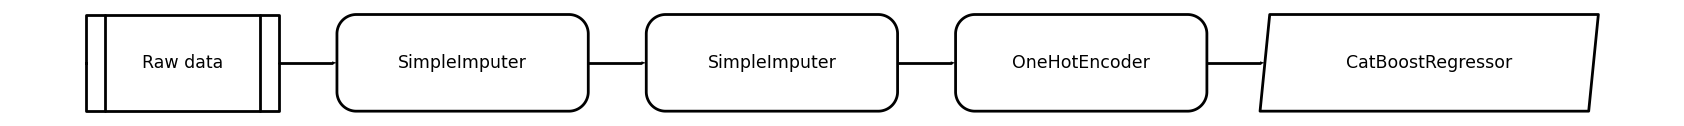

In [53]:
evaluate_model(best)

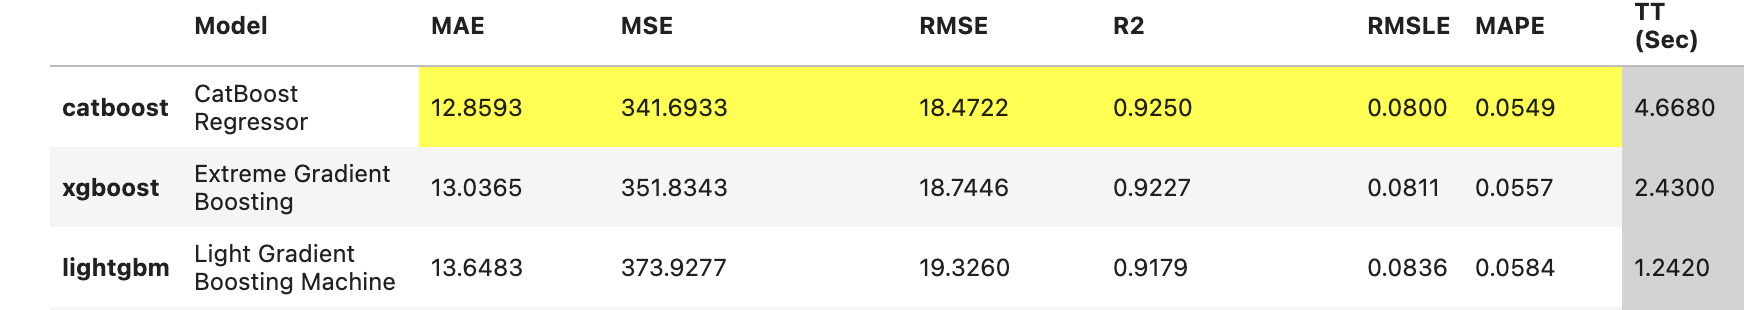

Disini kami memilih 3 algoritma machine learning ini sebagai algoritma yang akan kami eksperimenkan dalam data. Disini kami mendapatkan lightgbm adalah algoritma yang prediksinya paling sesuai untuk data setelah tuning parameter, walaupun dari prediksi pycaret catboost lah yang terbaik.

In [61]:
# Create LightGBM model
lightgbm_model = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,13.5766,371.5816,19.2765,0.9175,0.0825,0.0581
1,13.8364,386.6167,19.6626,0.9166,0.0855,0.0592
2,13.9682,411.1893,20.2778,0.9102,0.0852,0.0588
3,13.9738,400.9252,20.0231,0.9131,0.0851,0.0593
4,13.0340,329.5848,18.1545,0.9249,0.0784,0.0556
5,13.6333,365.2891,19.1125,0.9197,0.0848,0.0592
6,13.4002,347.8142,18.6498,0.9246,0.0830,0.0580
7,13.3851,345.4630,18.5866,0.9203,0.0834,0.0583
8,13.9487,394.3729,19.8588,0.9157,0.0856,0.0597


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

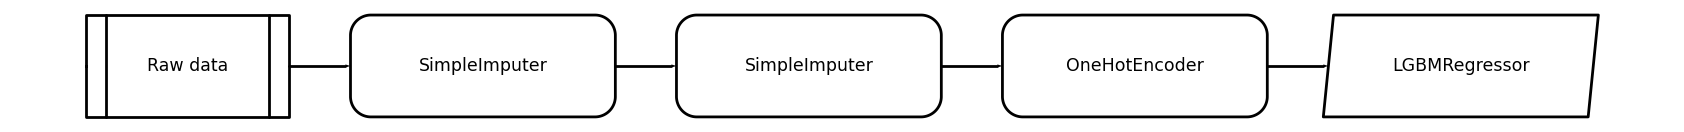

In [64]:
# Evaluate the LightGBM model
evaluate_model(lightgbm_model)

### Melakukan modelling dengan menggunakan lightgbm

In [ ]:
# Memastikan dataset yang akan diproses oleh lightgbm. 
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
train_data2 = lgb.Dataset(X, label=y)

# Parameter Lightgbm yang digunakan dari hasil tunning hyperparameter
params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 383,
    'learning_rate':  0.043473888565665246,
    'feature_fraction': 0.7062548984003787,
    'bagging_fraction': 0.569170227011523,
    'bagging_freq': 3,
    'min_child_samples': 200,
    'force_col_wise': True
}

# Melatih Model LightGBM
num_round = 1000
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])
bst2 = lgb.train(params, train_data2, num_round)

In [48]:
# Menyimpan model yang dilatih ke dalam file .pkl
pickle.dump(bst2, open('trained_model_full_data.pkl', 'wb'))  # Menyimpan model bst2

In [49]:
# Melakukan Prediksi Pada Dataset 
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

In [50]:
# Mengevaluasi model dengan metrik RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Mean Squared Error on the test set: {mse}')
print(f'Root Mean Squared Error on the test set: {rmse}')

Mean Squared Error on the test set: 333.0478268089643
Root Mean Squared Error on the test set: 18.249597990338426


## Submission

In [51]:
# Membaca file csv dataset test yang telah disiapkan
test_data_path = "/kaggle/input/test-tentan-prepro/Test_Tentan.csv"  # Adjust the path as needed
df_test = pd.read_csv(test_data_path)

# Memastikan variabel kategorik yang digunakan
categorical_features = ['Make', 'Transmission', 'Vehicle', 'Fuel']
for feature in categorical_features:
    df_test[feature] = df_test[feature].astype('category')

# Menyiapkan variabel yang akan digunakan
features = [col for col in df_test.columns if col not in ('Unnamed: 0', 'CO2 Emissions(g/km)')]  

# Melakukan prediksi
y_pred_test = bst2.predict(df_test[features], num_iteration=bst2.best_iteration)

# Membaca sample submission file
sample_submission_path = "/kaggle/input/dataslayer/sample_submission.csv"  # Adjust the path as needed
df_submission = pd.read_csv(sample_submission_path)

# Mengisi nilai pada variabel 'CO2 Emissions(g/km)' menggunakan hasil prediksi yang diberikan model y_pred_test
df_submission['CO2 Emissions(g/km)'] = y_pred_test

# Menyimpan hasil modifikasi submission kedalam file csv baru
updated_submission_path = "Updated_Submission12.csv"
df_submission.to_csv(updated_submission_path, index=False)
print('The predictions have been saved to Updated_Submission12.csv')

The predictions have been saved to Updated_Submission12.csv
